# Pycle demo 3: quantized sketches
In this demo notebook, we simply show how to sketch with quantized features, and how to recover the same cost by hybrid sketch matching.

We assume that you have installed `pycle` with `pip` or that you have the `pycle` folder in the same directory as this notebook.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Fix the random seed for reproducibility
np.random.seed(42)

We again use our synthetic GMM dataset.

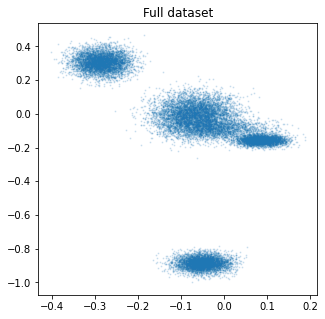

In [2]:
from pycle.utils import generatedataset_GMM

d = 2     # Dimension
K = 5     # Number of Gaussians
n = 20000 # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
X = generatedataset_GMM(d,K,n,normalize='l_inf-unit-ball',balanced=False) 

# Bounds on the dataset, necessary for compressive k-means
bounds = np.array([-np.ones(d),np.ones(d)]) # We assumed the data is normalized between -1 and 1

# Visualize the dataset
plt.figure(figsize=(5,5))
plt.title("Full dataset")
plt.scatter(X[:,0],X[:,1],s=1, alpha=0.15)
plt.show()

We compute the quantized sketch of the dataset, given by

$$ \boldsymbol z_q = \sum_{\boldsymbol x_i \in X} \Phi_q(\boldsymbol x_i) = \sum_{\boldsymbol x_i \in X} q(\Omega^T\boldsymbol x_i + \boldsymbol \xi), $$

where $q : \mathbb R \mapsto \{\pm 1 \pm \mathrm{i}\}$ is the ($2\pi$-periodic) universal quantization funtion $q = \mathrm{sign} \circ \exp(\mathrm i \cdot)$  (a square wave), and $\xi_j$ are dithering values, drawn independently uniformly in $[0,2\pi)$.

In [3]:
import pycle.sketching as sk

# As usual: sketch dimension, draw the frequencies
m = 10*K*d # Sketch dimension
Sigma = 0.01*np.eye(d)
Omega = sk.drawFrequencies("FoldedGaussian",d,m,Sigma) # Draw frequencies

# Draw the dithering xi
xi = sk.drawDithering(m)

# Define the feature map as the complex universal quantization
Phi_q = sk.SimpleFeatureMap("universalQuantization_complex",Omega,xi) 

print("Some entries of one sketch contribution: ",Phi_q(X[0])[:8]) # Takes 2m bits to encode

# Compute the sketch with those quantized features
z_q = sk.computeSketch(X,Phi_q)

Some entries of one sketch contribution:  [ 1.-1.j  1.+1.j -1.+1.j  1.-1.j  1.-1.j  1.-1.j  1.+1.j  1.+1.j]


To learn from this quantized sketch without changing the desired cost function, it has been shown that we can use the full-precision features during reconstruction. We thus first construct the full precision feature map, then pass the quantized sketch along with this feature map to the learning algorithm.

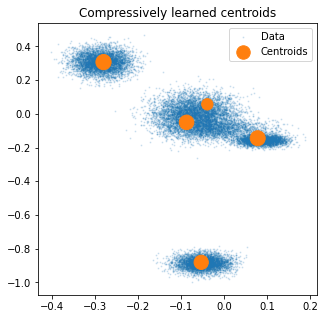

In [4]:
import pycle.compressive_learning as cl

Phi_fullprec = sk.SimpleFeatureMap("ComplexExponential",Omega,xi,c_norm = (np.pi/2*np.sqrt(2)))

# Notice how we pass the full-precision featuremap to the learning algorithm
kmeans_solver = cl.CLOMP_CKM(Phi_fullprec, K, bounds, z_q)
kmeans_solver.fit_several_times(5)
(weights,centroids) = kmeans_solver.current_sol

# Visualize the centroids (we re-use the dataset for visual comparison)
plt.figure(figsize=(5,5))
plt.title("Compressively learned centroids")
plt.scatter(X[:,0],X[:,1],s=1, alpha=0.15)
plt.scatter(centroids[:,0],centroids[:,1],s=1000*weights)
plt.legend(["Data","Centroids"])
plt.show()